# Neural Networks 101 with `gluon` - Part II

Now that you know how to implement a multilayer perceptron,
we'll demonstrate how to implement a convolutional neural network, a popular approach for working with images. 

In [21]:
import d2l
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
from matplotlib import pyplot as plt

ctx = d2l.try_gpu()

## `Block` composition and LeNet

`gluon` makes it easy to combine `Block`s in various ways to build composite `Block`s.

One easy way is to use `gluon.nn.Sequential`, which takes an arbitrary number of `Block`s
as parameters and runs them in Sequence, passing the output each `Block` as the input to its sucessor, finally returning the output of the last `Block`. 

Once we've defined a composite `Block` via `Sequential`, we can treat in turn, string these composite `Block`s together to build even more elaborate structures.

The following code implements a famous network called LeNet through nn.Sequential.

In [2]:
lenet = nn.Sequential()

In [3]:
lenet.add(
    nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Flatten(),
    nn.Dense(120, activation="relu"),
    nn.Dense(84, activation="relu"),
    nn.Dense(10))

In [4]:
lenet

Sequential(
  (0): Conv2D(None -> 6, kernel_size=(5, 5), stride=(1, 1), Activation(relu))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (2): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (4): Flatten
  (5): Dense(None -> 120, Activation(relu))
  (6): Dense(None -> 84, Activation(relu))
  (7): Dense(None -> 10, linear)
)

## `HybridBlock` (Just-in-time compilation)

1. `gluon`: easy to program with native Python structures
1. overhead: context switching between Python and MXNet backend
1. hybridize: Just in time compilation 

`gluon` makes it easy to program with native Python structures, with nice benefits like making it easy to debug, all the context switching between Python and MXNet's low-level scheduler does come with some overhead. Once you're settled in your model and want to speed it up, Gluon's `HybridBlock`s help you to double the speed of your model by compiling the model, cutting down on context switiching and applying a number of intelligent optimizations to eliminate redundant computation and use memory efficiently.

Hybridizing is very easy. Every Block provides a `.hybridize()` method which will hybridize the Block itself if possible or calls `.hybridize()` on all the `Block`s it is composed of.

In [5]:
lenet.hybridize(static_alloc=True, static_shape=True)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: All children of this Sequential layer 'sequential0_' are HybridBlocks. Consider using HybridSequential for the best performance.
  """Entry point for launching an IPython kernel.


``` python
class HybridNet(gluon.HybridBlock):
    def forward(self, F, x):
        # Computation based on other `HybridBlock`
```

In [6]:
lenet = nn.HybridSequential()
lenet.add(
    nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Flatten(),
    nn.Dense(120, activation="relu"),
    nn.Dense(84, activation="relu"),
    nn.Dense(10))

In [7]:
lenet.hybridize(static_alloc=True, static_shape=True)

In [8]:
lenet

HybridSequential(
  (0): Conv2D(None -> 6, kernel_size=(5, 5), stride=(1, 1), Activation(relu))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (2): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (4): Flatten
  (5): Dense(None -> 120, Activation(relu))
  (6): Dense(None -> 84, Activation(relu))
  (7): Dense(None -> 10, linear)
)

### Initialization

In [9]:
lenet.initialize(ctx=ctx)
# Input shape is (batch_size, color_channels, height, width)
x = nd.random.uniform(shape=(4,1,28,28), ctx=ctx)
y = lenet(x)
y.shape

(4, 10)

In [10]:
lenet

HybridSequential(
  (0): Conv2D(1 -> 6, kernel_size=(5, 5), stride=(1, 1), Activation(relu))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (2): Conv2D(6 -> 16, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (4): Flatten
  (5): Dense(400 -> 120, Activation(relu))
  (6): Dense(120 -> 84, Activation(relu))
  (7): Dense(84 -> 10, linear)
)

### MNIST

In [11]:
def normalize_and_copy(dataset, ctx):
    data = mx.nd.array(dataset._data, ctx=ctx) \
                .transpose((0, 3, 1, 2)) \
                .astype(np.float32)/255
    label = dataset._label
    output = gluon.data.ArrayDataset(data, label)
    output._data[1] = mx.nd.array(label, ctx=ctx)
    return output

In [12]:
train_data = normalize_and_copy(gluon.data.vision.MNIST(train=True), ctx)
test_data = normalize_and_copy(gluon.data.vision.MNIST(train=False), ctx)

In [13]:
batch_size = 64

train_batches = mx.gluon.data.DataLoader(train_data, batch_size, shuffle=True)
test_batches = mx.gluon.data.DataLoader(test_data, batch_size, shuffle=False)

In [14]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(lenet.collect_params(), 'sgd', {'learning_rate': .02})

### Evaluation

In [15]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        prediction = net(data).argmax(axis=-1, keepdims=True)
        acc.update(preds=prediction, labels=label)
    return acc.get()[1]

### Training

In [16]:
epochs = 10

In [17]:
for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_batches):
        with autograd.record():
            output = lenet(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss)

    train_accuracy = evaluate_accuracy(train_batches, lenet)
    test_accuracy = evaluate_accuracy(test_batches, lenet)
    print("Epoch %s. Loss: %.4f, Train_acc %.4f, Test_acc %.4f" %
          (e, cumulative_loss.asscalar()/len(train_data), train_accuracy, test_accuracy))

Epoch 0. Loss: 2.2992, Train_acc 0.1231, Test_acc 0.1256
Epoch 1. Loss: 1.3316, Train_acc 0.8753, Test_acc 0.8855
Epoch 2. Loss: 0.3181, Train_acc 0.8972, Test_acc 0.9029
Epoch 3. Loss: 0.1906, Train_acc 0.9534, Test_acc 0.9559
Epoch 4. Loss: 0.1386, Train_acc 0.9607, Test_acc 0.9598
Epoch 5. Loss: 0.1124, Train_acc 0.9720, Test_acc 0.9708
Epoch 6. Loss: 0.0962, Train_acc 0.9740, Test_acc 0.9719
Epoch 7. Loss: 0.0833, Train_acc 0.9773, Test_acc 0.9762
Epoch 8. Loss: 0.0743, Train_acc 0.9768, Test_acc 0.9759
Epoch 9. Loss: 0.0675, Train_acc 0.9817, Test_acc 0.9790


## Recurrent Neural Network

<img src="../img/rnn_unfold.png">

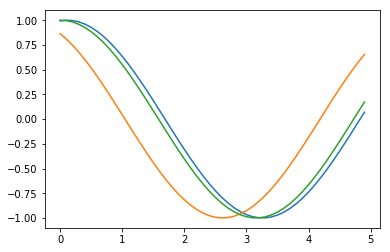

In [22]:
def generate_sine_data(batch_size, start, stop, step):
    phase = mx.random.uniform(-np.pi*2, np.pi*2, shape=(1, batch_size))
    x = (mx.nd.arange(start, stop, step).expand_dims(1) + phase)
    return x.sin()
x = generate_sine_data(3, 0, 5, 0.1)
plt.plot(np.arange(0, 5, 0.1), x.asnumpy())

In [23]:
cell = gluon.rnn.LSTMCell(10)
cell.initialize()
rnn_input = x.expand_dims(2)
rnn_output, _ = cell.unroll(50, rnn_input, layout='TNC', merge_outputs=True)
print(rnn_input.shape, rnn_output.shape)

(50, 3, 1) (50, 3, 10)
